### !!!Conclusion: we can't obtain the rational dem difference map for the study region and thus fail to estimate the c-band penetration.


In [2]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import glob
from utils.geotif_io import readTiff, writeTiff
import matplotlib.pyplot as plt
from utils.crop_to_extent import crop_to_extent
from utils.raster_vec import vec2mask


In [3]:
path_srtm_l3_align = config.root_proj + '/data/dem/srtm-c/SRTMGL3_v1/srtml3_wgs84V_utm_align.tif'
path_srtm_x = config.root_proj + '/data/dem/srtm-x/srtm_x_utm.tif'


In [4]:
srtm_l3_align, srtm_l3_align_info = readTiff(path_srtm_l3_align)
srtm_x, srtm_x_info = readTiff(path_srtm_x)
srtm_x = np.ma.masked_equal(srtm_x, 0)
print('srtm_c_l3:', srtm_l3_align_info)
print('srtm_x:', srtm_x_info)


srtm_c_l3: {'geoextent': (419391.6113126002, 585919.5646432166, 3862794.8176520756, 3967981.5287020416), 'geotrans': (419391.6113126002, 26.508747744447046, 0.0, 3967981.5287020416, 0.0, -26.50874774444709), 'geosrs': '32644', 'row': 3968, 'col': 6282, 'bands': 1}
srtm_x: {'geoextent': (419391.61130260024, 585919.5646253139, 3862794.8176692203, 3967981.5287141944), 'geotrans': (419391.61130260024, 26.508747743189044, 0.0, 3967981.5287141944, 0.0, -26.508747743189044), 'geosrs': '32644', 'row': 3968, 'col': 6282, 'bands': 1}


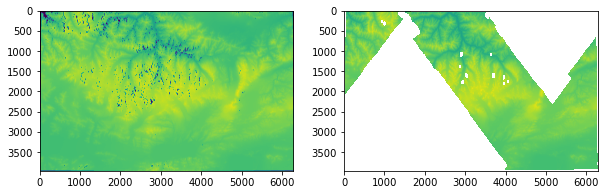

In [5]:
plt.figure(figsize=(10,5))
# plt.subplot(1,2,1); plt.imshow(srtm_c, vmax=7000, vmin=0)
plt.subplot(1,2,1); plt.imshow(srtm_l3_align, vmax=7000, vmin=0)
plt.subplot(1,2,2); plt.imshow(srtm_x, vmax=7000, vmin=0)



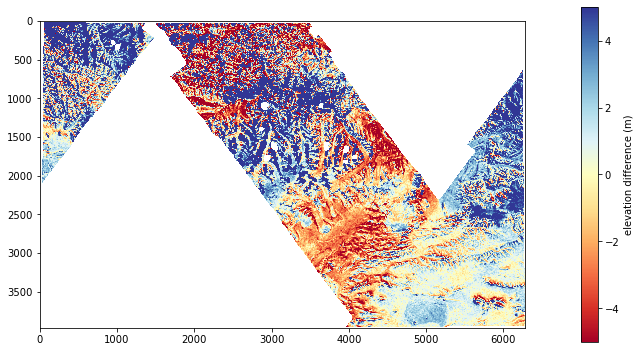

In [6]:
dif_dem = srtm_x - srtm_l3_align
plt.figure(figsize=(10,8))
plt.imshow(dif_dem, vmin=-5, vmax=5, cmap='RdYlBu')
cb = plt.colorbar(fraction=0.03, pad=0.1); 
cb.set_label('elevation difference (m)')


### mask

In [7]:
path_water_jrc = config.root_proj + '/data/water_jrc/wkl_water_jrc_utm.tif'      # jrc water map
path_rgi_1305 = config.root_proj + '/data/rgi/rgi60_1305/rgi60_1305.shp'     # rgi glacier data
water_jrc, water_jrc_info = readTiff(path_water_jrc)


In [8]:
### 1. water mask
extent_base = srtm_l3_align_info['geoextent']
size_base = [srtm_l3_align_info['row'], srtm_l3_align_info['col']]
water_jrc_crop = crop_to_extent(path_img=path_water_jrc, \
                                  extent_target=extent_base, size_target=size_base)
water_jrc_crop = np.ma.masked_where(water_jrc_crop>50, water_jrc_crop)
water_mask = water_jrc_crop.mask
### 2. rgi mask
rgi_img = vec2mask(path_raster=path_srtm_l3_align, path_vec=path_rgi_1305, path_save=None)
rgi_img = np.ma.masked_equal(rgi_img, 1)
rgi_mask = rgi_img.mask
## 3. bare land mask 
land_mask = ~np.logical_or(water_mask, rgi_mask)


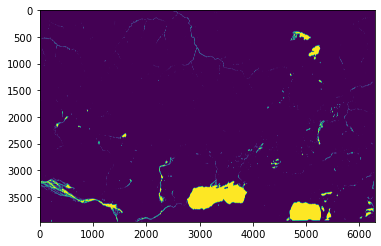

In [9]:
plt.imshow(water_mask)


### apply mask

In [10]:
dif_dem_glacier = np.ma.array(dif_dem, mask=~rgi_mask, fill_value=0).astype(np.float32).filled(np.nan)
dif_dem_land = np.ma.array(dif_dem, mask=~land_mask, fill_value=0).astype(np.float32).filled(np.nan)


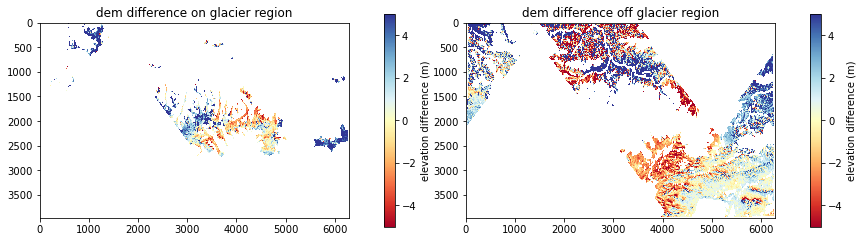

In [91]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(dif_dem_glacier, vmax=5, vmin=-5, cmap='RdYlBu')
plt.title('dem difference on glacier region'); 
cb = plt.colorbar(fraction=0.03, pad=0.1); 
cb.set_label('elevation difference (m)')

plt.subplot(1,2,2)
plt.imshow(dif_dem_land, vmax=5, vmin=-5, cmap='RdYlBu')
plt.title('dem difference off glacier region'); 
cb = plt.colorbar(fraction=0.03, pad=0.1); 
cb.set_label('elevation difference (m)')



### plot elevation-dif figure

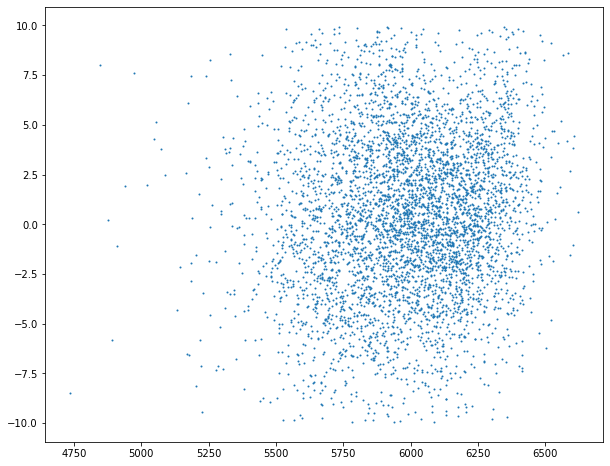

In [139]:
idx_glacier_sel = np.where((np.abs(dif_dem_glacier)<10) & (~np.isnan(dif_dem_glacier)))
# idx_glacier_filter = np.where((np.abs(dif_dem_glacier)>10) | (np.isnan(dif_dem_glacier)))
dif_dem_glacier_ = dif_dem[idx_glacier_sel]
srtm_x_glacier_ = srtm_x[idx_glacier_sel]
plt.figure(figsize=(10,8))
plt.scatter(srtm_x_glacier_[::500], dif_dem_glacier_[::500], s=1)



### Plot slope-dif figure

In [140]:
from pybob.GeoImg import GeoImg
import pybob.coreg_tools as ct

srtm_x_geo = GeoImg(path_srtm_x)
slope_srtm_x = ct.get_slope(srtm_x_geo)  # calculate slope from master DEM

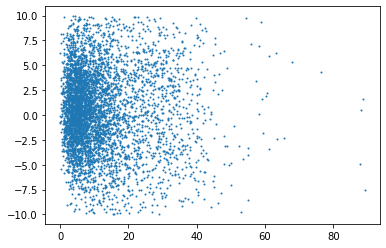

In [142]:
slope_glacier_ = slope_srtm_x.img[idx_glacier_sel]
plt.scatter(slope_glacier_[::500], dif_dem_glacier_[::500], s=1)


array([89.42243 , 89.42274 , 89.46265 , ..., 15.79756 , 16.676569,
       16.328691], dtype=float32)